In [12]:
import pandas as pd
import os
import json
from pymongo import MongoClient
import matplotlib.pyplot as plt
DATA = '../../../../data/'


In [2]:
def decorateRow(row):
    #['HEX_600', 'HEX_weighted_average_distance', 'HEX_weighted_mean_home_distance', 'HEX_weighted_max_home_distance', 'HEX_weighted_median_home_distance', 'HEX_weighted_radius_of_gyration', 'HEX_weighted_num_reporting_2015', 'HEX_weighted_HEX_coverage', 'HEX_weighted_subject_coverage', 'HEX_weighted_subject_hhi', 'HEX_total_reporting', 'HEX_total_user']
    record = row[1:].to_frame().transpose()
    return record

In [3]:
#Connect to client
client = MongoClient('localhost', 27017)
db = client['boston311']
hexagon_coll = db['bos311Hex']
# Drop it if it exsits.
hexagon_coll.drop() 

In [2]:
data_all = pd.read_csv(DATA + "hex_variables_all/poverty_added_01_hex_variables_non_gov_regardless_of_reporting_frequency_20210209.csv", sep='\t', header=0, index_col = 0)
data_all.columns

Index(['HEX_600', 'HEX_weighted_average_distance',
       'HEX_weighted_mean_home_distance', 'HEX_weighted_max_home_distance',
       'HEX_weighted_median_home_distance', 'HEX_weighted_radius_of_gyration',
       'HEX_weighted_num_reporting_2015', 'HEX_weighted_HEX_coverage',
       'HEX_weighted_subject_coverage', 'HEX_weighted_subject_hhi',
       'HEX_total_reporting', 'HEX_total_user',
       'HEX_normalized_total_311_per_100',
       'HEX_num_311_including_government_users', 'HEX_total_population',
       'HEX_income_below_poverty', 'HEX_below_poverty_unemployed',
       'HEX_above_poverty_unemployed', 'HEX_total_housing_units',
       'HEX_Owner_occupied_housing_units', 'HEX_Renter_occupied_housing_units',
       'HEX_less_than_bacholar', 'HEX_estimate_total_for_degree',
       'HEX_White_population', 'HEX_Black_or_African_American_population',
       'HEX_American_Indian_and_Alaska_Native_population',
       'HEX_Asian_population',
       'HEX_Native_Hawaiian_and_Other_Pacific_I

In [17]:
data_all[['poverty_index', 'HEX_total_reporting']]

,poverty_index,HEX_total_reporting
0,0.633361,36
1,0.384339,10404
2,0.384339,6561
3,0.384339,25
4,-1.289402,324
...,...,...
382,-1.475081,729
383,-2.114815,196
384,-1.278515,2401
385,-1.089533,8100


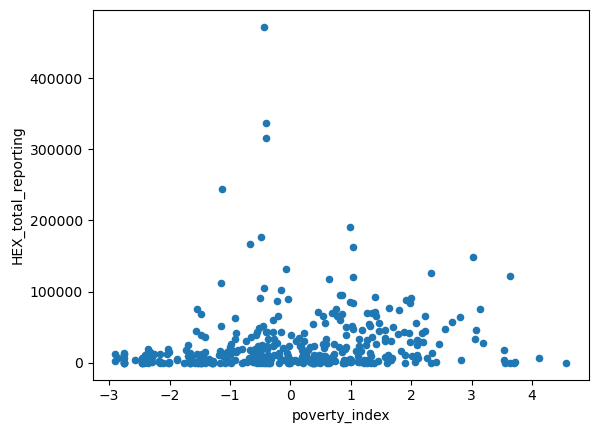

In [20]:
ax1 = data_all[['poverty_index', 'HEX_total_reporting']].plot.scatter(x='poverty_index',y = "HEX_total_reporting")
plt.show()

In [5]:
# all subjects
#Initialize collection
data_all = pd.read_csv(DATA + "hex_variables_all/poverty_added_01_hex_variables_non_gov_regardless_of_reporting_frequency_20210209.csv", sep='\t', header=0, index_col = 0)
#Adding object for each hexagon
#Object has 2 values: hexagon number and array of objects for data from each user type and frequency on hexagon
for index, row in data_all.iterrows():
    hexagon_coll.insert_one({
        'HEX_600': row.HEX_600,
        'results': []
    })
#Populating with data
all_dir = DATA + "hex_variables_all/"
for filename in os.listdir(all_dir):
    if filename.endswith(".csv"):
        data_all= pd.read_csv(os.path.join(all_dir, filename), sep='\t', header=0, index_col=0)
        data_all['reason'] = "all"
        for index, row in data_all.iterrows():
            # Append new object from file to existing hexagon's array
            hexagon_coll.update_one({
                'HEX_600': row.HEX_600,
            },
            {
                '$push': 
                {
                    'results': json.loads(decorateRow(row).to_json(orient='records'))[0]
                }
            })

In [6]:
# by reasons
reason_dir = DATA + "hex_variables_of_selected_five_reasons_for_viz_system_20220928/"
for reason in os.listdir(reason_dir):
    if reason!=".DS_Store":
        directory = reason_dir + reason + "/"
       
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                frequency = "all"
                if filename.startswith("01"):
                    user_type = "non_gov"
                elif filename.startswith("02"):
                    user_type = "non_gov_unsure"
                elif filename.startswith("03"):
                    user_type = "all"
                elif filename.startswith("04"):
                    user_type = "non_gov"
                    frequency = "heavy"
                elif filename.startswith("05"):
                    user_type = "non_gov_unsure"
                    frequency = "heavy"
                elif filename.startswith("06"):
                    user_type = "all"
                    frequency = "heavy"
                
                data_per_reason = pd.read_csv(os.path.join(directory, filename), header=0, index_col = 0)
                data_per_reason.rename(columns={"HEX":"HEX_600","HEX_total_number_of_reports":"HEX_total_reporting"}, inplace=True)

                data_per_reason['reason'] = reason
                data_per_reason['user_type'] = user_type
                data_per_reason['frequency'] = frequency
                data = data_per_reason.merge(data_all, on = 'HEX_600')
                data = data.loc[:, ~data.columns.str.contains('_y$')]
                data.columns = data.columns.str.replace(r'_x$', '')
                for index, row in data.iterrows():
                    # Append new object from file to existing hexagon's array
                    hexagon_coll.update_one({
                        'HEX_600': row.HEX_600,
                    },
                    {
                        '$push': 
                        {
                            'results': json.loads(decorateRow(row).to_json(orient='records'))[0]
                        }
                    })
                

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: The default value of regex will change from True to False in a future version.


In [7]:
for doc in hexagon_coll.find({"HEX_600": 233}):
    for rec in doc['results']:
        print(rec['user_type'])
        print(rec['frequency'])
        print(rec['HEX_weighted_mean_home_distance'])
        print(rec['reason'])

non_gov
all
1148.3605439858
all
non_gov_unsure
all
1148.3605439858
all
all
heavy
2207.9177425439
all
non_gov
heavy
1373.6741484277
all
all
all
1800.193646956
all
non_gov_unsure
heavy
1373.6741484277
all
all
heavy
None
Code_Enforcement
all
all
1886.5682666012
Code_Enforcement
non_gov_unsure
all
1886.5682666012
Code_Enforcement
non_gov
all
1886.5682666012
Code_Enforcement
non_gov
heavy
None
Code_Enforcement
non_gov_unsure
heavy
None
Code_Enforcement
all
heavy
None
Housing
all
all
1173.9546020273
Housing
non_gov_unsure
all
1173.9546020273
Housing
non_gov
all
1173.9546020273
Housing
non_gov
heavy
None
Housing
non_gov_unsure
heavy
None
Housing
all
heavy
3845.1225486112
Highway_Maintenance
all
all
1613.9915902082
Highway_Maintenance
non_gov_unsure
all
1295.2585961506
Highway_Maintenance
non_gov
all
1295.2585961506
Highway_Maintenance
non_gov
heavy
None
Highway_Maintenance
non_gov_unsure
heavy
None
Highway_Maintenance
all
heavy
136.2255260344
Sanitation
all
all
44.0864138792
Sanitation
non_go

In [ ]:
# by types
# type_dir = DATA + "hex_variables_of_top_five_types_for_viz_system_20220923/"
# for report_type in os.listdir(type_dir):
#     if report_type!=".DS_Store":
#         directory = type_dir + report_type + "/"
       
#         for filename in os.listdir(directory):
#             if filename.endswith(".csv"):
#                 frequency = "all"
#                 if filename.startswith("01"):
#                     user_type = "non_gov"
#                 elif filename.startswith("02"):
#                     user_type = "non_gov_unsure"
#                 elif filename.startswith("03"):
#                     user_type = "all"
#                 elif filename.startswith("04"):
#                     user_type = "non_gov"
#                     frequency = "heavy"
#                 elif filename.startswith("05"):
#                     user_type = "non_gov_unsure"
#                     frequency = "heavy"
#                 elif filename.startswith("06"):
#                     user_type = "all"
#                     frequency = "heavy"
                
#                 data_per_type = pd.read_csv(os.path.join(directory, filename), header=0, index_col = 0)
#                 data_per_type.rename(columns={"HEX":"HEX_600","HEX_total_number_of_reports":"HEX_total_reporting"}, inplace=True)

#                 data_per_type['report_type'] = report_type
#                 data_per_type['user_type'] = user_type
#                 data_per_type['frequency'] = frequency
#                 data = data_per_type.merge(data_all_report_types, on = 'HEX_600')
#                 data = data.loc[:, ~data.columns.str.contains('_y$')]
#                 data.columns = data.columns.str.replace(r'_x$', '')
#                 for index, row in data.iterrows():
#                     # Append new object from file to existing hexagon's array
#                     hexagon_coll.update_one({
#                         'HEX_600': row.HEX_600,
#                     },
#                     {
#                         '$push': 
#                         {
#                             'results': json.loads(decorateRow(row).to_json(orient='records'))[0]
#                         }
#                     })
                

In [5]:
# # by subjects
# subject_dir = DATA + "hex_variables_by_subjects_for_viz_system_20220623/"
# for subject in os.listdir(subject_dir):
#     if subject!=".DS_Store":
#         directory = subject_dir + subject + "/"
#         for filename in os.listdir(directory):
#             if filename.endswith(".csv"):
#                 frequency = "all"
#                 if filename.startswith("01"):
#                     user_type = "non_gov"
#                 elif filename.startswith("02"):
#                     user_type = "non_gov_unsure"
#                 elif filename.startswith("03"):
#                     user_type = "all"
#                 elif filename.startswith("04"):
#                     user_type = "non_gov"
#                     frequency = "heavy"
#                 elif filename.startswith("05"):
#                     user_type = "non_gov_unsure"
#                     frequency = "heavy"
#                 elif filename.startswith("06"):
#                     user_type = "all"
#                     frequency = "heavy"
                
#                 data_per_subject = pd.read_csv(os.path.join(directory, filename), header=0, index_col = 0)
#                 data_per_subject.rename(columns={"HEX":"HEX_600","HEX_total_number_of_reports":"HEX_total_reporting"}, inplace=True)

#                 data_per_subject['subject'] = subject
#                 data_per_subject['user_type'] = user_type
#                 data_per_subject['frequency'] = frequency
#                 data = data_per_subject.merge(data_all_subjects, on = 'HEX_600')
#                 data = data.loc[:, ~data.columns.str.contains('_y$')]
#                 data.columns = data.columns.str.replace(r'_x$', '')
#                 for index, row in data.iterrows():
#                     # Append new object from file to existing hexagon's array
#                     hexagon_coll.update_one({
#                         'HEX_600': row.HEX_600,
#                     },
#                     {
#                         '$push': 
#                         {
#                             'results': json.loads(decorateRow(row).to_json(orient='records'))[0]
#                         }
#                     })
                

<ipython-input-5-73716f42e040>:33: FutureWarning: The default value of regex will change from True to False in a future version.
  data.columns = data.columns.str.replace(r'_x$', '')


In [ ]:
# mongodump --db=boston311